# Wavenet

In this lecture, we will: <br>
1. More characters as the input
2. Complexify the architecture instead of the single hidden layer (so 'savour the information contained in it')

__Description:__<br>
We take the 2-layer MLP from previous video and make it deeper with a tree-like structure, arriving at a convolutional neural network architecture similar to the [WaveNet (2016) from DeepMind](https://arxiv.org/pdf/1609.03499). In the WaveNet paper, the same hierarchical architecture is implemented more efficiently using causal dilated convolutions (not yet covered). Along the way we get a better sense of torch.nn and what it is and how it works under the hood, and what a typical deep learning development process looks like (a lot of reading of documentation, keeping track of multidimensional tensor shapes, moving between jupyter notebooks and repository code, ...).


In [7]:
import torch 
import torch.nn as nn 
import matplotlib.pyplot as plt

# to ensure changes in aux_files are reflected dynamically
import importlib
import aux_files
importlib.reload(aux_files)
from aux_files import Linear, BatchNorm1d, Tanh

In [8]:
words = open('names.txt').read().splitlines()

In [9]:
allchars = sorted(set(''.join(words)))

stoi = {s:i+1 for i,s in enumerate(allchars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

In [10]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
words_shuffled = words[:]  # shallow copy -- to preserve across runs
random.shuffle(words_shuffled)
n1 = int(0.8*len(words_shuffled))
n2 = int(0.9*len(words_shuffled))

Xtr,  Ytr  = build_dataset(words_shuffled[:n1])     # 80%
Xdev, Ydev = build_dataset(words_shuffled[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words_shuffled[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [11]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [20]:
g = torch.Generator().manual_seed(3445676536)

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd))

layers = [
    Linear(n_embd*block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), 
    Linear(n_hidden, vocab_size, bias=True)
]

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


In [21]:
# Optimization loop - same as earlier

max_iters = 200000
batch_size = 32
lossi = []

for iter in range(max_iters):

    # define batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # inputs
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # concat input

    # forward pass
    for layer in layers:
        x = layer(x)
    loss = nn.functional.cross_entropy(x, Yb)

    # backward pass
    for p in parameters:
        p.grad = None # flush gradients
    loss.backward()

    # update - SGD
    lr = 0.1 if iter < 100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad

    #print
    lossi.append(loss.item())
    if iter % 10000 == 0:
        print(f'iter: {iter}/{max_iters}: loss = {loss.item()}')
    


iter: 0/200000: loss = 3.350454807281494
iter: 10000/200000: loss = 2.2377240657806396
iter: 20000/200000: loss = 2.3222482204437256
iter: 30000/200000: loss = 2.1089274883270264
iter: 40000/200000: loss = 2.3734750747680664
iter: 50000/200000: loss = 1.9449373483657837
iter: 60000/200000: loss = 2.444355010986328
iter: 70000/200000: loss = 1.7832374572753906
iter: 80000/200000: loss = 2.430109739303589
iter: 90000/200000: loss = 2.0311551094055176
iter: 100000/200000: loss = 2.369619131088257
iter: 110000/200000: loss = 2.157886505126953
iter: 120000/200000: loss = 1.9858556985855103
iter: 130000/200000: loss = 1.8881502151489258
iter: 140000/200000: loss = 2.359052896499634
iter: 150000/200000: loss = 1.8444346189498901
iter: 160000/200000: loss = 2.050384998321533
iter: 170000/200000: loss = 1.9287792444229126
iter: 180000/200000: loss = 2.1787221431732178
iter: 190000/200000: loss = 1.812082052230835


The `lossi` plot is too jagged; party because of the __small batch size__ - the randomness in batch gradient is too volatile. Lets fix this. 

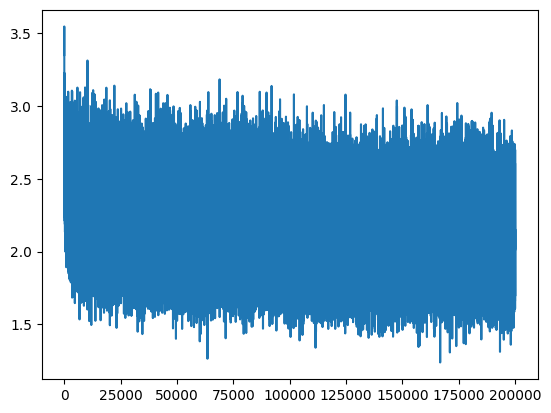

In [22]:
# plot lossi 
plt.plot(lossi)
plt.show()

In [23]:
# to ensure batch norm parameters are not trainined on eval data!
for layer in layers:
    layer.training = False

In [25]:
@torch.no_grad()
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = torch.nn.functional.cross_entropy(x, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')


train 2.064779281616211
val 2.110368013381958


In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)      
      x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      for layer in layers:
        x = layer(x)
      # ------------
      # Sample
      probs = torch.nn.functional.softmax(x, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))